[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025/blob/main/analysis_scripts/DEseq.ipynb)

In [1]:
# import packages

import os, sys
sys.path.append('../')
from pathlib import Path

import time

# numbers
import numpy as np
import pandas as pd
import scipy

# sc
import anndata
import scanpy as sc

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

import statsmodels.api as sm


# plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

from rat_friend import *


In [2]:
os.chdir('/home/coakes/rat/')

In [3]:
color_dict = {'male': '#E07F80',
            'female': '#317EC2',
              'transcript':'#E0AFCA',
              'gene':'#8D3666',
              'Other' : '#d8dcd6'
}

color_opts =  np.array([
    "#D55E00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#E69F00", "#CC79A7", "#666666", "#AD7700", "#1C91D4", "#007756", "#D5C711", "#005685",
    "#A04700", "#B14380", "#4D4D4D", "#FFBE2D", "#80C7EF", "#00F6B3", "#F4EB71", "#06A5FF", "#FF8320", "#D99BBD", "#8C8C8C", "#FFCB57", "#9AD2F2",
    "#2CFFC6", "#F6EF8E", "#38B7FF", "#FF9B4D", "#E0AFCA", "#A3A3A3", "#8A5F00", "#1674A9", "#005F45", "#AA9F0D", "#00446B", "#803800", "#8D3666",
    "#3D3D3D"
])
#8D3666, E0AFCA
tissues = ['ADRNL','BAT','BLOOD','COLON','CORTEX','HEART','HIPPOC','HYPOTH',
 'KIDNEY','LIVER', 'LUNG','OVARY','SKM-GN','SKM-VL','SMLINT','SPLEEN','TESTES','VENACV','WAT']
for x in range(len(tissues)):
    color_dict[tissues[x]] = color_opts[x]

color_dict

{'male': '#E07F80',
 'female': '#317EC2',
 'transcript': '#E0AFCA',
 'gene': '#8D3666',
 'Other': '#d8dcd6',
 'ADRNL': '#D55E00',
 'BAT': '#56B4E9',
 'BLOOD': '#009E73',
 'COLON': '#F0E442',
 'CORTEX': '#0072B2',
 'HEART': '#E69F00',
 'HIPPOC': '#CC79A7',
 'HYPOTH': '#666666',
 'KIDNEY': '#AD7700',
 'LIVER': '#1C91D4',
 'LUNG': '#007756',
 'OVARY': '#D5C711',
 'SKM-GN': '#005685',
 'SKM-VL': '#A04700',
 'SMLINT': '#B14380',
 'SPLEEN': '#4D4D4D',
 'TESTES': '#FFBE2D',
 'VENACV': '#80C7EF',
 'WAT': '#00F6B3'}

# Deseq Model Generation

## Load Transcript Data and Model

In [4]:
og_adata = anndata.read_h5ad('omics_adata/rat_transcript_meta.h5ad')
og_adata.obs.time = og_adata.obs.time.astype('int')
og_adata.layers["counts"] = og_adata.X.copy()
adata = og_adata[:,og_adata.layers['counts'].sum(axis=0) > 10]

# remove tissues that cause problems for inference due to missing values
adata = adata[[x not in ['VENACV', 'TESTES', 'OVARY'] for x in adata.obs.tissue.values]]
transcripts = adata.var.gene_id.values
adata

View of AnnData object with n_obs × n_vars = 783 × 72010
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'pid', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'group', 'rank', 'nid', 'num_umi', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [5]:
inference = DefaultInference()
transcript_dds = DeseqDataSet(
    counts=adata.layers['counts'],
    metadata=adata.obs[['nid', 'tissue', 'sex', 'time']],
    design = '~tissue + sex + time + tissue:time',
    inference=inference,
)
transcript_dds.deseq2()

Fitting size factors...
... done in 2.50 seconds.

Fitting dispersions...
... done in 59.42 seconds.

Fitting dispersion trend curve...
... done in 6.80 seconds.

Fitting MAP dispersions...
... done in 59.97 seconds.

Fitting LFCs...
... done in 44.53 seconds.

Calculating cook's distance...
... done in 8.30 seconds.

Replacing 0 outlier genes.



## Load Gene Data and Model

In [6]:
og_adata = anndata.read_h5ad("omics_adata/rat_RNA_meta.h5ad")
og_adata.obs.time = og_adata.obs.time.astype('int')
og_adata.layers["counts"] = og_adata.X.copy()
adata = og_adata[:,og_adata.layers['counts'].sum(axis=0) > 10]
# remove tissues that cause problems for inference due to missing values
adata = adata[[x not in ['VENACV', 'TESTES', 'OVARY'] for x in adata.obs.tissue.values]]
genes = adata.var.gene_id.values
adata

View of AnnData object with n_obs × n_vars = 783 × 24762
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [7]:
inference = DefaultInference()
gene_dds = DeseqDataSet(
    counts=adata.layers['counts'],
    metadata=adata.obs[['nid', 'tissue', 'sex', 'time']],
    design = '~tissue + sex + time + tissue:time',
    inference=inference,
)
gene_dds.deseq2()

Fitting size factors...
... done in 1.00 seconds.

Fitting dispersions...
... done in 23.75 seconds.

Fitting dispersion trend curve...
... done in 4.12 seconds.

Fitting MAP dispersions...
... done in 21.07 seconds.

Fitting LFCs...
... done in 13.85 seconds.

Calculating cook's distance...
... done in 2.55 seconds.

Replacing 0 outlier genes.



## Statistical Tests (in SKM-GN tissue)

In [8]:
toi = 'SKM-GN'
contrast_vector = np.ones(len(transcript_dds.obsm['design_matrix'].columns)) * np.array([('time' in x and toi in x) for x in transcript_dds.obsm['design_matrix'].columns.values])
#keep intercept
contrast_vector[0] = 1
contrast_vector

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [9]:
stat_res_transcript = DeseqStats(transcript_dds, 
                                 contrast = contrast_vector,
                                 inference=inference)
stat_res_transcript.summary()
transcript_res = stat_res_transcript.results_df
transcript_res['gene_id'] = transcripts
transcript_res.sort_values(['padj'], ascending=True).iloc[0:25,:]

Running Wald tests...
... done in 22.00 seconds.



Log2 fold change & Wald test p-value, contrast vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0.]
         baseMean  log2FoldChange      lfcSE        stat    pvalue      padj
0        0.208095       -1.624965   0.654220   -2.483819  0.012998  0.016417
1      907.026142        9.306545   0.051166  181.888471  0.000000  0.000000
2      157.772603        5.044004   0.103229   48.862328  0.000000  0.000000
3       13.480834        7.521125   0.130213   57.760215  0.000000  0.000000
4       10.467944        4.744011   0.081755   58.026948  0.000000  0.000000
...           ...             ...        ...         ...       ...       ...
72005   10.541612       -0.122234   0.301725   -0.405117  0.685391  0.735301
72006    1.114098       -3.330473   0.813510   -4.093955  0.000042  0.000064
72007    0.177731       -3.318728   0.968286   -3.427427  0.000609  0.000833
72008    2.053803       -2.572082   0.675755   -3.806233  0.000141  0.000

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
46631,259.351517,7.942632,0.057946,137.069465,0.0,0.0,ENSRNOT00000105819
20770,353.334059,10.084367,0.037489,268.993863,0.0,0.0,ENSRNOT00000037710
20769,948.854607,9.756695,0.021957,444.353851,0.0,0.0,ENSRNOT00000086796
20766,415.721784,9.953265,0.057606,172.781100,0.0,0.0,ENSRNOT00000044893
20763,1055.159989,10.282251,0.023498,437.575518,0.0,0.0,ENSRNOT00000029753
20762,182.144475,6.068439,0.067780,89.531732,0.0,0.0,ENSRNOT00000113713
20759,275.598021,6.934679,0.048663,142.503327,0.0,0.0,ENSRNOT00000100492
20757,189.580274,6.343036,0.055396,114.504196,0.0,0.0,ENSRNOT00000012306
20755,320.005855,5.154235,0.120988,42.601296,0.0,0.0,ENSRNOT00000080675
20751,3980.120096,10.298929,0.067080,153.531560,0.0,0.0,ENSRNOT00000015122


In [10]:
stat_res_gene = DeseqStats(gene_dds, 
                                 contrast = contrast_vector,
                           inference=inference)
stat_res_gene.summary()
gene_res = stat_res_gene.results_df
gene_res['gene_id'] = genes
gene_res.sort_values(['padj'], ascending=True).iloc[0:25,:]

Running Wald tests...
... done in 7.26 seconds.



Log2 fold change & Wald test p-value, contrast vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0.]
          baseMean  log2FoldChange     lfcSE        stat        pvalue  \
0        18.458399        2.584696  0.136203   18.976732  2.656132e-80   
1       568.277005        1.435135  0.239322    5.996662  2.014148e-09   
2        42.168148        5.122679  0.092423   55.426191  0.000000e+00   
3         1.013414       -0.473452  0.383027   -1.236080  2.164290e-01   
4       123.117689       -0.326961  0.341528   -0.957347  3.383922e-01   
...            ...             ...       ...         ...           ...   
24757     3.256219        1.704049  0.212685    8.012090  1.127751e-15   
24758     2.665649       -1.866471  0.487194   -3.831061  1.275917e-04   
24759    63.267534        6.222913  0.074527   83.499231  0.000000e+00   
24760   734.219984        9.344533  0.048993  190.733836  0.000000e+00   
24761  1236.942011        8.7

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
20780,214.177166,10.123175,0.041740,242.531672,0.0,0.0,ENSRNOG00000065506
20775,71.519066,5.250167,0.090979,57.707571,0.0,0.0,ENSRNOG00000065497
20764,311.524196,7.441165,0.089136,83.481199,0.0,0.0,ENSRNOG00000065474
20766,24.142283,4.835643,0.074157,65.208426,0.0,0.0,ENSRNOG00000065478
20769,266.506016,8.058688,0.036902,218.378142,0.0,0.0,ENSRNOG00000065487
20770,27.329525,5.539120,0.102802,53.881291,0.0,0.0,ENSRNOG00000065488
20821,29.991952,5.256063,0.073462,71.548179,0.0,0.0,ENSRNOG00000065566
20822,62.354557,4.955307,0.131234,37.759453,0.0,0.0,ENSRNOG00000065567
9489,168.597321,6.774476,0.067434,100.460376,0.0,0.0,ENSRNOG00000018760
9490,3179.388220,11.763421,0.021010,559.904239,0.0,0.0,ENSRNOG00000018761


## Attach Gene Metadata

In [11]:
gene_meta = pd.read_csv('t2go.csv')
transcript_res = pd.merge(transcript_res, gene_meta, left_on= 'gene_id', right_on='ensembl_transcript_id', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
gene_res = pd.merge(gene_res, gene_meta, left_on='gene_id', right_on='ensembl_gene_id', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)').groupby('gene_id').first().reset_index().drop('ensembl_transcript_id', axis=1)

## Show Most Significant Gene Level Changes Over Time

In [12]:
gene_filtered = gene_res[(gene_res.padj < .05) & (np.abs(gene_res.log2FoldChange) > 10)]
old_genes = gene_filtered[genes_in_original(gene_filtered.gene_id.values, og_supp_table=4)]
new_genes = gene_filtered[[x not in old_genes.gene_id.values for x in gene_filtered.gene_id.values]]
print(gene_filtered.shape, old_genes.shape, new_genes.shape)

(2897, 15) (28, 15) (2869, 15)


In [13]:
old_genes.sort_values(['log2FoldChange'], ascending=False, key=abs).iloc[0:5,:]

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,X3,X4,X5,X6,X7,X8,description
18440,ENSRNOG00000061262,6276.598772,12.904692,0.019070,676.692786,0.0,0.0,ENSRNOG00000061262,Huwe1,Huwe1-201,X,20873795,21001262,+,"protein polyubiquitination, ubiquitin-protein ..."
4814,ENSRNOG00000009790,967.119438,12.775915,0.076660,166.657789,0.0,0.0,ENSRNOG00000009790,Kcnk3,Kcnk3-201,6,25763228,25799153,-,"monoatomic ion channel activity, open rectifie..."
13258,ENSRNOG00000029614,777.681112,12.583916,0.054239,232.008584,0.0,0.0,ENSRNOG00000029614,Robo1,Robo1-201,11,10580908,11620203,+,cell migration involved in sprouting angiogene...
15935,ENSRNOG00000047247,4124.909442,12.218692,0.043678,279.747909,0.0,0.0,ENSRNOG00000047247,Ptprs,Ptprs-201,9,1245410,1306947,-,"phosphoprotein phosphatase activity, protein t..."
4648,ENSRNOG00000009449,2792.287492,12.030934,0.036569,328.994651,0.0,0.0,ENSRNOG00000009449,Trim35,Trim35-201,15,40493755,40510240,+,"protein binding, zinc ion binding, positive re..."


In [14]:
new_genes.sort_values(['log2FoldChange'], ascending=False, key=abs).iloc[0:10,:]

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,X3,X4,X5,X6,X7,X8,description
6923,ENSRNOG00000013890,0.495134,-63.185601,12.260252,-5.153695,2.554029e-07,3.585578e-07,ENSRNOG00000013890,Crx,Crx-201,1,76540141,76545818,-,"DNA-binding transcription factor activity, RNA..."
4855,ENSRNOG00000009875,2886.767011,15.867156,0.334265,47.468748,0.000000e+00,0.000000e+00,ENSRNOG00000009875,Akr1b7,Akr1b7-201,4,63076800,63089502,+,oxidoreductase activity
155,ENSRNOG00000000428,2127.467417,15.128021,0.122647,123.345582,0.000000e+00,0.000000e+00,ENSRNOG00000000428,Cyp21a1,Cyp21a1-201,20,4023767,4026923,+,"monooxygenase activity, iron ion binding, oxid..."
7523,ENSRNOG00000015052,2229.716972,15.121855,0.073513,205.703541,0.000000e+00,0.000000e+00,ENSRNOG00000015052,Star,Star-201,16,66264807,66271672,-,"mitochondrion, steroid biosynthetic process, g..."
14399,ENSRNOG00000034234,77190.765575,15.112375,0.057257,263.937530,0.000000e+00,0.000000e+00,ENSRNOG00000034234,Mt-co1,Mt-co1-201,MT,5323,6867,+,"cytochrome-c oxidase activity, mitochondrion, ..."
13803,ENSRNOG00000031766,59895.414355,15.046043,0.048488,310.303114,0.000000e+00,0.000000e+00,ENSRNOG00000031766,Mt-cyb,Mt-cyb-201,MT,14136,15278,+,"mitochondrion, mitochondrial inner membrane, m..."
13538,ENSRNOG00000030700,63913.557866,15.042209,0.048071,312.916107,0.000000e+00,0.000000e+00,ENSRNOG00000030700,Mt-co3,Mt-co3-201,MT,8599,9382,+,"cytochrome-c oxidase activity, mitochondrial r..."
13850,ENSRNOG00000031979,58056.390327,15.033381,0.044204,340.090392,0.000000e+00,0.000000e+00,ENSRNOG00000031979,Mt-atp6,Mt-atp6-201,MT,7919,8599,+,mitochondrial proton-transporting ATP synthase...
13277,ENSRNOG00000029707,54872.586429,15.016530,0.047360,317.070268,0.000000e+00,0.000000e+00,ENSRNOG00000029707,Mt-nd4,Mt-nd4-201,MT,10160,11537,+,"mitochondrial inner membrane, mitochondrial re..."
13459,ENSRNOG00000030371,52169.320738,15.008581,0.045344,330.994564,0.000000e+00,0.000000e+00,ENSRNOG00000030371,Mt-co2,Mt-co2-201,MT,7006,7689,+,"cytochrome-c oxidase activity, copper ion bind..."


## Plot Top Genes of Interest Over Time

- Mt-cyb = mitochondrial gene, response to nutrient/hormone/hypoxia/hyperoxia 
- Huwe1 = metabolic process

In [15]:
goi = ['ENSRNOG00000061262', 'ENSRNOG00000031766'] 

og_adata = anndata.read_h5ad("omics_adata/rat_RNA_meta.h5ad")
og_adata.obs.time = og_adata.obs.time.astype('int')
og_adata.layers["counts"] = og_adata.X.copy()
small_gene_adata = og_adata[:,og_adata.var.gene_id.isin(goi)]
#small_gene_adata.var.head()

In [16]:
summary_df = pd.DataFrame(small_gene_adata.layers['counts'])
summary_df.columns = small_gene_adata.var.X3.values
summary_df['time'] = small_gene_adata.obs.time.values
summary_df['tissue'] = small_gene_adata.obs.tissue.values
summary_df['sex'] = small_gene_adata.obs.sex.values
summary_df = pd.melt(summary_df, ['time', 'tissue', 'sex'], var_name = 'gene', value_name = 'gene_count')
summary_df.head()

,time,tissue,sex,gene,gene_count
0,1,SKM-GN,female,Mt-cyb,59239.0
1,4,SKM-GN,male,Mt-cyb,62824.0
2,4,SKM-GN,male,Mt-cyb,63209.0
3,1,SKM-GN,female,Mt-cyb,61390.0
4,0,SKM-GN,female,Mt-cyb,60997.0


/tmp/ipykernel_1987619/444957391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


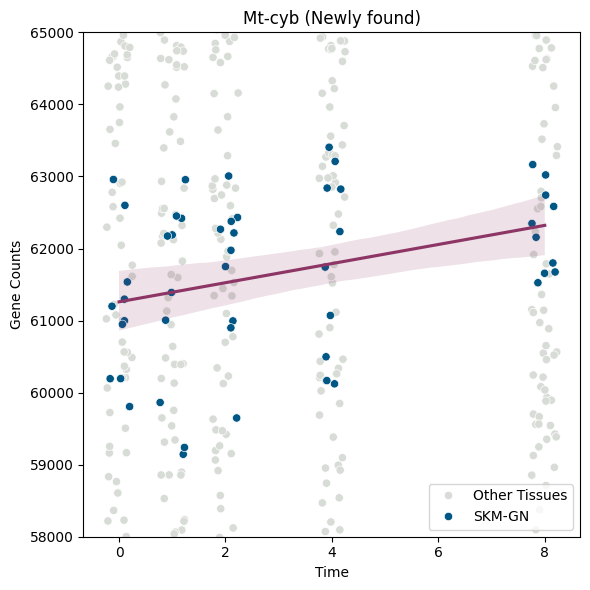

In [17]:
curr_goi = small_gene_adata.var.X3.values[0]
small_df = summary_df[summary_df.gene == curr_goi]
small_df.loc[:,'tissue'] = small_df.tissue == toi
small_df.loc[:,'tissue'] = [toi if x else 'Other' for x in small_df.tissue.values]
small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))

plt.figure(figsize=(6, 6))
g = sns.scatterplot(
        data=small_df.sort_values('tissue'), x='jiggle_time', y='gene_count',
    hue = 'tissue',
    palette = color_dict,
        )
sns.regplot(
        data=small_df[small_df.tissue.isin([toi])], x='time', y='gene_count',
    color = color_dict['gene'],scatter=False
)
handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, ['Other Tissues', toi], loc='lower right')
plt.xlabel('Time')
plt.ylabel('Gene Counts')
plt.ylim([58000, 65000])
plt.title(f'{curr_goi} (Newly found)')
plt.tight_layout()
plt.savefig('figures_final/fig_2a.png')
plt.show()

/tmp/ipykernel_1987619/241510348.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


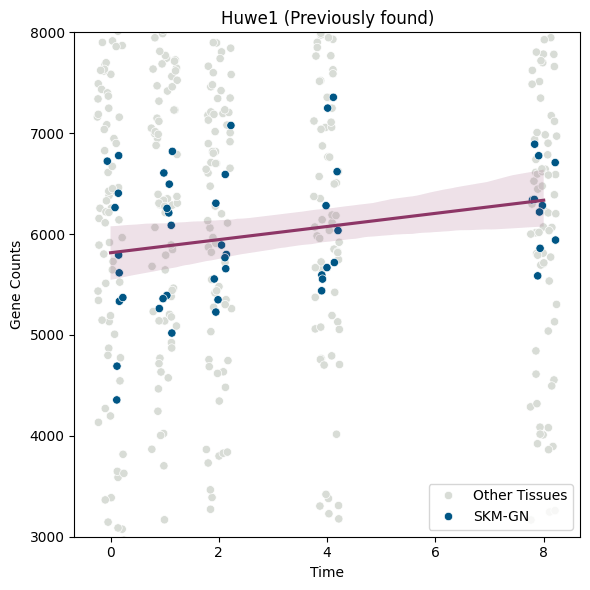

In [18]:
curr_goi = small_gene_adata.var.X3.values[1]
small_df = summary_df[summary_df.gene == curr_goi]
small_df.loc[:,'tissue'] = small_df.tissue == toi
small_df.loc[:,'tissue'] = [toi if x else 'Other' for x in small_df.tissue.values]
small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))

plt.figure(figsize=(6, 6))
g = sns.scatterplot(
        data=small_df.sort_values('tissue'), x='jiggle_time', y='gene_count',
    hue = 'tissue',
    palette = color_dict,
        )
sns.regplot(
        data=small_df[small_df.tissue.isin([toi])], x='time', y='gene_count',
    color = color_dict['gene'],scatter=False
)
handles, labels  =  g.get_legend_handles_labels()

g.legend(handles, ['Other Tissues', toi], loc='lower right')
plt.xlabel('Time')
plt.ylabel('Gene Counts')
#plt.yscale('log', base=2)
plt.ylim([3000, 8000])
plt.title(f'{curr_goi} (Previously found)')
plt.tight_layout()
plt.savefig('figures_final/fig_2b.png')
plt.show()

# Isoform vs Gene Level P-Values

In [19]:
t2_full = transcript_res[['baseMean', 'log2FoldChange', 'padj', 'ensembl_transcript_id', 'ensembl_gene_id', 'X3']]
t2_full = t2_full.groupby(['ensembl_gene_id', 'X3'])[['baseMean', 'log2FoldChange', 'padj', 'ensembl_transcript_id']].agg(lambda x: list(x))
t2_small = t2_full.apply(lambda x: lancaster(x.padj, np.log(x.baseMean/np.min(x.baseMean))+1), axis=1).reset_index()
t2_small.columns = ['ensembl_gene_id', 'X3', 'lancaster']
t2_full = pd.merge(t2_full, t2_small, on=['ensembl_gene_id', 'X3'], how='left', suffixes=('', '_transcript'))

/tmp/ipykernel_1987619/4050584871.py:3: RuntimeWarning: divide by zero encountered in divide
  t2_small = t2_full.apply(lambda x: lancaster(x.padj, np.log(x.baseMean/np.min(x.baseMean))+1), axis=1).reset_index()
/tmp/ipykernel_1987619/4050584871.py:3: RuntimeWarning: invalid value encountered in divide
  t2_small = t2_full.apply(lambda x: lancaster(x.padj, np.log(x.baseMean/np.min(x.baseMean))+1), axis=1).reset_index()


In [20]:
big_comp = pd.merge(gene_res, t2_full, on='ensembl_gene_id', how='left', suffixes=('', '_transcript'))
big_comp['pval_diff'] = big_comp.padj-big_comp.lancaster
big_comp['LFC'] = np.abs(big_comp.log2FoldChange)
big_comp.head()

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,X3,X4,...,X8,description,X3_transcript,baseMean_transcript,log2FoldChange_transcript,padj_transcript,ensembl_transcript_id,lancaster,pval_diff,LFC
0,ENSRNOG00000000001,18.458399,2.584696,0.136203,18.976732,2.656132e-80,4.172810e-80,ENSRNOG00000000001,Arsj,Arsj-201,...,+,"sulfuric ester hydrolase activity, actin cytos...",Arsj,"[13.739765293189658, 4.607977394036107]","[2.0563446414688342, 0.652645940308668]","[2.4446480124625776e-42, 0.012971235608666662]","[ENSRNOT00000055633, ENSRNOG00000000001]",0.000000,4.172810e-80,2.584696
1,ENSRNOG00000000007,568.277005,1.435135,0.239322,5.996662,2.014148e-09,2.861009e-09,ENSRNOG00000000007,Gad1,Gad1-201,...,+,"catalytic activity, glutamate decarboxylase ac...",Gad1,"[421.92382548804363, 0.2675234462717402, 101.0...","[-3.156684466808172, -2.6572928979323893, -1.0...","[5.627199124926793e-05, 0.008510926412955385, ...","[ENSRNOT00000000008, ENSRNOT00000084375, ENSRN...",0.000005,-4.876655e-06,1.435135
2,ENSRNOG00000000008,42.168148,5.122679,0.092423,55.426191,0.000000e+00,0.000000e+00,ENSRNOG00000000008,Alx4,Alx4-201,...,+,RNA polymerase II transcription regulatory reg...,Alx4,"[7.546527924100162, 0.8425167790320742, 34.144...","[2.947581054464105, -0.7647063378823351, 4.627...","[5.19701517377206e-26, 0.19465810736399475, 0.0]","[ENSRNOT00000000009, ENSRNOT00000114813, ENSRN...",0.000000,0.000000e+00,5.122679
3,ENSRNOG00000000009,1.013414,-0.473452,0.383027,-1.236080,2.164290e-01,2.387687e-01,ENSRNOG00000000009,Tmco5b,Tmco5b-201,...,+,None,Tmco5b,"[0.19831249459482292, 0.793670997665745]","[-2.933127963142921, -0.7404188339740497]","[0.0006028376890301297, 0.07522786449814163]","[ENSRNOT00000000010, ENSRNOG00000000009]",0.000797,2.379720e-01,0.473452
4,ENSRNOG00000000010,123.117689,-0.326961,0.341528,-0.957347,3.383922e-01,3.674725e-01,ENSRNOG00000000010,Cbln1,Cbln1-201,...,+,"protein binding, extracellular region, heterop...",Cbln1,"[116.67087430596739, 3.5156165389995757]","[-0.4657277935964415, -3.2047028890056835]","[0.22685173177730733, 4.251393695573737e-05]","[ENSRNOT00000000011, ENSRNOG00000000010]",0.000516,3.669564e-01,0.326961


In [21]:
toi_means = np.sum(og_adata[og_adata.obs.tissue == toi].layers['counts'], axis=0)
big_comp = pd.merge(big_comp, pd.DataFrame({'ensembl_gene_id':og_adata.var.ensembl_gene_id,
                                f'{toi}_means':toi_means}), on='ensembl_gene_id')
big_comp.head()

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,X3,X4,...,description,X3_transcript,baseMean_transcript,log2FoldChange_transcript,padj_transcript,ensembl_transcript_id,lancaster,pval_diff,LFC,SKM-GN_means
0,ENSRNOG00000000001,18.458399,2.584696,0.136203,18.976732,2.656132e-80,4.172810e-80,ENSRNOG00000000001,Arsj,Arsj-201,...,"sulfuric ester hydrolase activity, actin cytos...",Arsj,"[13.739765293189658, 4.607977394036107]","[2.0563446414688342, 0.652645940308668]","[2.4446480124625776e-42, 0.012971235608666662]","[ENSRNOT00000055633, ENSRNOG00000000001]",0.000000,4.172810e-80,2.584696,602.0
1,ENSRNOG00000000007,568.277005,1.435135,0.239322,5.996662,2.014148e-09,2.861009e-09,ENSRNOG00000000007,Gad1,Gad1-201,...,"catalytic activity, glutamate decarboxylase ac...",Gad1,"[421.92382548804363, 0.2675234462717402, 101.0...","[-3.156684466808172, -2.6572928979323893, -1.0...","[5.627199124926793e-05, 0.008510926412955385, ...","[ENSRNOT00000000008, ENSRNOT00000084375, ENSRN...",0.000005,-4.876655e-06,1.435135,302.0
2,ENSRNOG00000000008,42.168148,5.122679,0.092423,55.426191,0.000000e+00,0.000000e+00,ENSRNOG00000000008,Alx4,Alx4-201,...,RNA polymerase II transcription regulatory reg...,Alx4,"[7.546527924100162, 0.8425167790320742, 34.144...","[2.947581054464105, -0.7647063378823351, 4.627...","[5.19701517377206e-26, 0.19465810736399475, 0.0]","[ENSRNOT00000000009, ENSRNOT00000114813, ENSRN...",0.000000,0.000000e+00,5.122679,3565.0
3,ENSRNOG00000000009,1.013414,-0.473452,0.383027,-1.236080,2.164290e-01,2.387687e-01,ENSRNOG00000000009,Tmco5b,Tmco5b-201,...,None,Tmco5b,"[0.19831249459482292, 0.793670997665745]","[-2.933127963142921, -0.7404188339740497]","[0.0006028376890301297, 0.07522786449814163]","[ENSRNOT00000000010, ENSRNOG00000000009]",0.000797,2.379720e-01,0.473452,9.0
4,ENSRNOG00000000010,123.117689,-0.326961,0.341528,-0.957347,3.383922e-01,3.674725e-01,ENSRNOG00000000010,Cbln1,Cbln1-201,...,"protein binding, extracellular region, heterop...",Cbln1,"[116.67087430596739, 3.5156165389995757]","[-0.4657277935964415, -3.2047028890056835]","[0.22685173177730733, 4.251393695573737e-05]","[ENSRNOT00000000011, ENSRNOG00000000010]",0.000516,3.669564e-01,0.326961,42.0


- Myl2 = muscle, normally heart-specific 

signficant with lancaster only: 726
signficant with genes only: 401
signficant with both: 18217


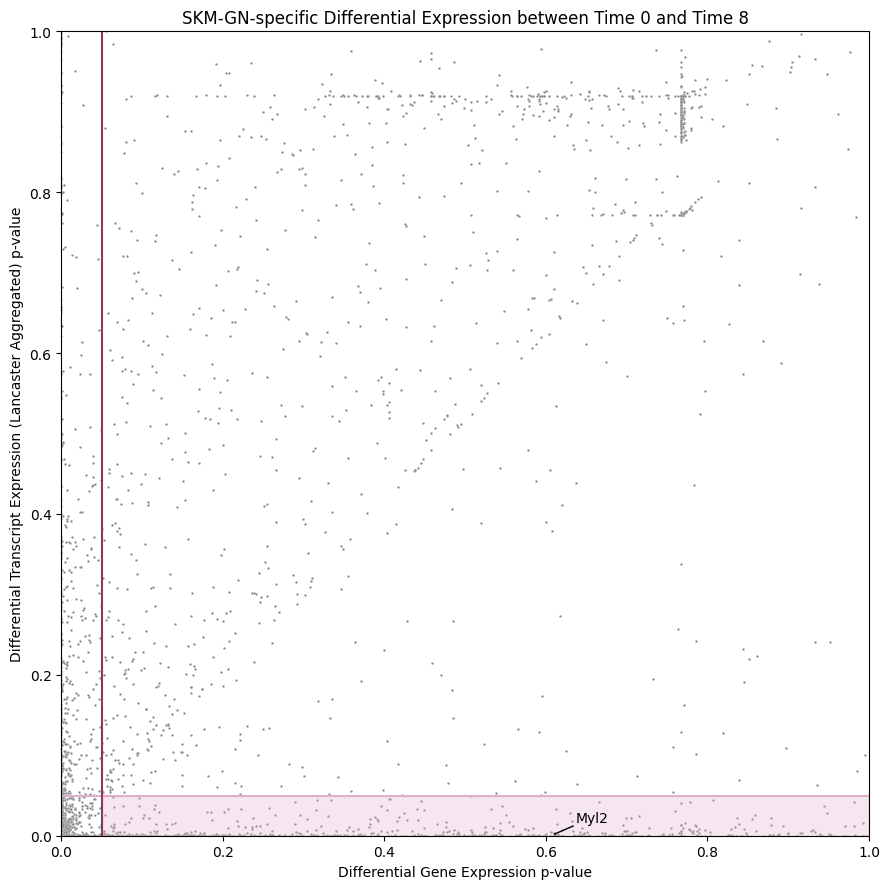

In [22]:
print('signficant with lancaster only:', np.sum((big_comp.lancaster <.05) & (big_comp.padj > .05)))
print('signficant with genes only:', np.sum((big_comp.padj <.05) & (big_comp.lancaster > .05)))
print('signficant with both:', np.sum((big_comp.lancaster <.05) & (big_comp.padj < .05)))
goi = 'ENSRNOG00000030848'
fig, ax = plt.subplots(figsize=(9, 9))
sns.scatterplot(big_comp, y = 'lancaster', x = 'padj', 
                #hue='log2FoldChange', 
                s = 3, c = 'grey')#, alpha=1)
plt.axvspan(ymin = 0, ymax = .05, xmin = .05, xmax=1,color=color_dict['transcript'], alpha = .3)
texts = [plt.text(x=big_comp.loc[big_comp.gene_id==goi, 'padj'], y=big_comp.loc[big_comp.gene_id==goi, 'lancaster'], 
         s=big_comp.loc[big_comp.gene_id==goi, 'X3'].values[0])]
adjust_text(texts, expand=(2, 2),
            target_y = big_comp.loc[big_comp.gene_id==goi, 'lancaster'],
            arrowprops=dict(arrowstyle="->", color='black'))
plt.plot([0, 1], [.05, .05], c=color_dict['transcript'])
plt.plot([.05, .05], [0, 1], c=color_dict['gene'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Differential Transcript Expression (Lancaster Aggregated) p-value')
plt.xlabel('Differential Gene Expression p-value')
plt.title('SKM-GN-specific Differential Expression between Time 0 and Time 8')
plt.tight_layout()
#sns.move_legend(ax, 'right', bbox_to_anchor=(1.25, .5))
plt.savefig(f'figures_final/fig_2c.png')
plt.show()

# Isoform Level Significance, no Gene Level Significance

In [23]:
big_comp[big_comp.ensembl_gene_id == goi]

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,X3,X4,...,description,X3_transcript,baseMean_transcript,log2FoldChange_transcript,padj_transcript,ensembl_transcript_id,lancaster,pval_diff,LFC,SKM-GN_means
13571,ENSRNOG00000030848,4361.278117,-0.288456,0.510583,-0.564954,0.572105,0.605913,ENSRNOG00000030848,Myl2,Myl2-201,...,"calcium ion binding, A band, metal ion binding",Myl2,"[3975.687954252118, 113.85239551401578, 6.1814...","[-1.2206142970582192, -3.0694986543548963, -3....","[0.47313279497477373, 0.00023713723253099728, ...","[ENSRNOT00000050368, ENSRNOT00000095667, ENSRN...",6.313479e-09,0.605913,0.288456,464220.0


## Reload Transcript Level Data for this Gene

In [24]:
og_adata = anndata.read_h5ad('omics_adata/rat_RNA_transcript_meta.h5ad')
og_adata.obs.time = og_adata.obs.time.astype('int')
og_adata.layers["counts"] = og_adata.X.copy()
small_transcript_adata = og_adata[:,og_adata.var.ensembl_gene_id == goi]
small_transcript_adata

View of AnnData object with n_obs × n_vars = 861 × 5
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'nid', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'ensembl_transcript_id', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8', 'description', 'n_counts'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

## Reload Gene Level Data for this Gene

In [25]:
og_adata = anndata.read_h5ad("omics_adata/rat_RNA_meta.h5ad")
og_adata.obs.time = og_adata.obs.time.astype('int')
og_adata.layers["counts"] = og_adata.X.copy()
small_gene_adata = og_adata[:,og_adata.var.gene_id == goi]
small_gene_adata

View of AnnData object with n_obs × n_vars = 861 × 1
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [26]:
goi_df = big_comp[big_comp.ensembl_gene_id == goi]
goi_df

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,X3,X4,...,description,X3_transcript,baseMean_transcript,log2FoldChange_transcript,padj_transcript,ensembl_transcript_id,lancaster,pval_diff,LFC,SKM-GN_means
13571,ENSRNOG00000030848,4361.278117,-0.288456,0.510583,-0.564954,0.572105,0.605913,ENSRNOG00000030848,Myl2,Myl2-201,...,"calcium ion binding, A band, metal ion binding",Myl2,"[3975.687954252118, 113.85239551401578, 6.1814...","[-1.2206142970582192, -3.0694986543548963, -3....","[0.47313279497477373, 0.00023713723253099728, ...","[ENSRNOT00000050368, ENSRNOT00000095667, ENSRN...",6.313479e-09,0.605913,0.288456,464220.0


## Summarize per-Tissue Expression

In [27]:
summary_df = pd.DataFrame(small_transcript_adata.layers['counts'])
summary_df.columns = small_transcript_adata.var.ensembl_transcript_id.values
summary_df['Sum'] = small_gene_adata.layers['counts'][:,0]
summary_df['time'] = small_transcript_adata.obs.time.values
summary_df['tissue'] = small_transcript_adata.obs.tissue.values
summary_df['sex'] = small_transcript_adata.obs.sex.values
summary_df = pd.melt(summary_df, ['time', 'tissue', 'sex'], var_name = 'Gene/Transcript', value_name = 'gene_count')

gene_name = goi_df.X3.values[0]
gene_name_dict = {}
for x in range(len(goi_df.ensembl_transcript_id.values[0])-1):
    curr_pval = goi_df.padj_transcript.values[0][x]
    if curr_pval < .05:
        gene_name_dict[goi_df.ensembl_transcript_id.values[0][x]] = f'{gene_name} Spliced Transcript {x+1} \n pval = {'{:0.3e}'.format(curr_pval)}'
    else:
        gene_name_dict[goi_df.ensembl_transcript_id.values[0][x]] = f'{gene_name} Spliced Transcript {x+1} \n pval = {np.round(curr_pval,3)}'  
curr_pval = goi_df.padj_transcript.values[0][x+1]
if curr_pval < .05:
    gene_name_dict[goi_df.ensembl_transcript_id.values[0][x+1]] = f'{gene_name} Unspliced Transcript \n pval = {'{:0.3e}'.format(curr_pval)}'
else:
    gene_name_dict[goi_df.ensembl_transcript_id.values[0][x+1]] = f'{gene_name} Unspliced Transcript \n pval = {np.round(curr_pval,3)}'   
gene_name_dict['Sum'] = f'{gene_name} Gene Level Sum \n pval = {np.round(goi_df.padj.values[0], 3)}'

summary_df['Gene/Transcript'] = summary_df['Gene/Transcript'].replace(gene_name_dict)
summary_df['splice_type'] = ['gene' if 'Gene' in x else 'transcript' for x in summary_df['Gene/Transcript'].values]
summary_df[['tissue', 'gene_count']].groupby('tissue').sum()

,gene_count
tissue,
ADRNL,159.0
BAT,17761.0
BLOOD,501.0
COLON,679.0
CORTEX,146.0
HEART,5142361.0
HIPPOC,122.0
HYPOTH,124.0
KIDNEY,62.0


In [28]:
summary_df[['Gene/Transcript', 'gene_count']].groupby('Gene/Transcript').sum()

,gene_count
Gene/Transcript,
Myl2 Gene Level Sum \n pval = 0.606,3363852.0
Myl2 Spliced Transcript 1 \n pval = 0.473,2912248.0
Myl2 Spliced Transcript 2 \n pval = 2.371e-04,81032.0
Myl2 Spliced Transcript 3 \n pval = 4.868e-05,4312.0
Myl2 Spliced Transcript 4 \n pval = 2.679e-04,77985.0
Myl2 Unspliced Transcript \n pval = 1.043e-02,61613.0


## Plot Transcripts Over Time

/tmp/ipykernel_1987619/3547436069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


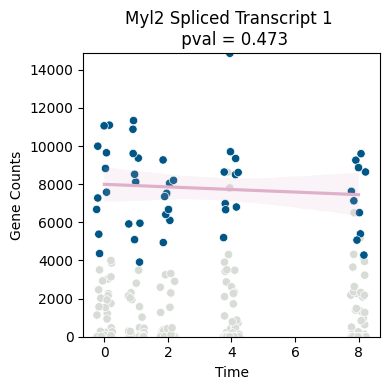

/tmp/ipykernel_1987619/3547436069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


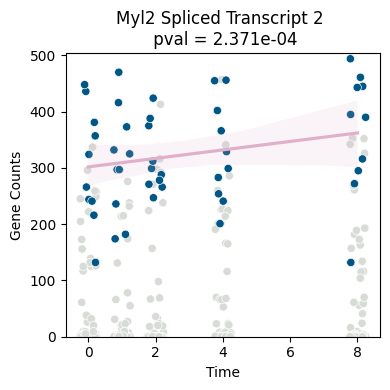

/tmp/ipykernel_1987619/3547436069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


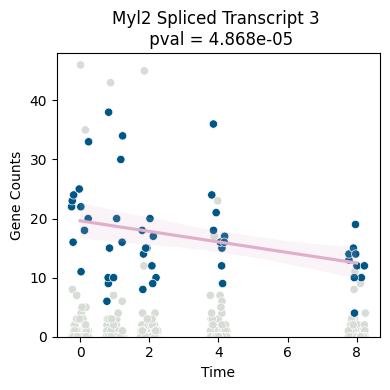

/tmp/ipykernel_1987619/3547436069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


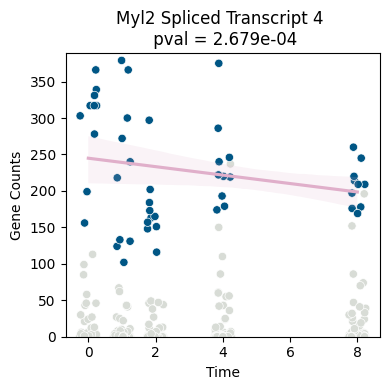

/tmp/ipykernel_1987619/3547436069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


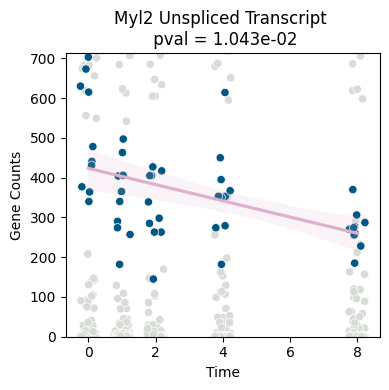

/tmp/ipykernel_1987619/3547436069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))


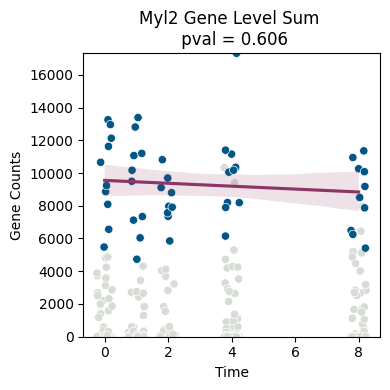

In [29]:
#curr_goi = summary_df['Gene/Transcript'].unique()[0]
axis_index = 0
axis_list = [[0, 100], [1000, 3000], [8000, 15000]]
for curr_goi in summary_df['Gene/Transcript'].unique():
    small_df = summary_df[summary_df['Gene/Transcript'] == curr_goi]
    small_df.loc[:,'tissue'] = small_df.tissue == toi
    small_df.loc[:,'tissue'] = [toi if x else 'Other' for x in small_df.tissue.values]
    small_df.loc[:,'jiggle_time'] = small_df.time + .25-.5*np.random.random(size = len(small_df.time.values))
    #small_df = small_df[small_df.sex == 'male']
    
    plt.figure(figsize=(4, 4))
    g = sns.scatterplot(
            data=small_df.sort_values('tissue',ascending=True), x='jiggle_time', y='gene_count',
        hue = 'tissue',
        #style = 'sex',
        palette = color_dict,
            )
    sns.regplot(
        data=small_df[small_df.tissue.isin([toi])], x='time', y='gene_count',
    color = color_dict[small_df.splice_type.values[0]],scatter=False
)
    #handles, labels  =  g.get_legend_handles_labels()
    
    #g.legend(handles, ['Other Tissues', 'SKM-GN'], loc='lower right')
    plt.legend([],[], frameon=False)
    plt.xlabel('Time')
    plt.ylabel('Gene Counts')
    plt.ylim([0, small_df[small_df.tissue.isin([toi])].gene_count.max()+10])
    #plt.ylim(axis_list[axis_index])
    plt.title(f'{curr_goi}')
    plt.tight_layout()
    plt.savefig(f'figures_final/fig_2{'defghi'[axis_index]}.png')
    axis_index+=1
    plt.show()
    plt.close()